In [1]:
# To make sure we are using gpu not cpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger

import tensorflow as tf

import pickle

from sklearn.metrics import classification_report,confusion_matrix

In [9]:
datagen = ImageDataGenerator(rescale = 1./255)

In [10]:

train = datagen.flow_from_directory('./Dataset/train/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate validation dataset
val = datagen.flow_from_directory('./Dataset/val/', target_size=(224, 224), class_mode='binary', batch_size=64)
# load and iterate test dataset
test = datagen.flow_from_directory('./Dataset/test/', target_size=(224, 224), class_mode='binary', batch_size=64)

Found 3816 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.


In [11]:
imgs, labels = next(train)

In [12]:
imgs.shape

(64, 224, 224, 3)

In [13]:
train.class_indices


{'Benign': 0, 'Malignant': 1}

1.0


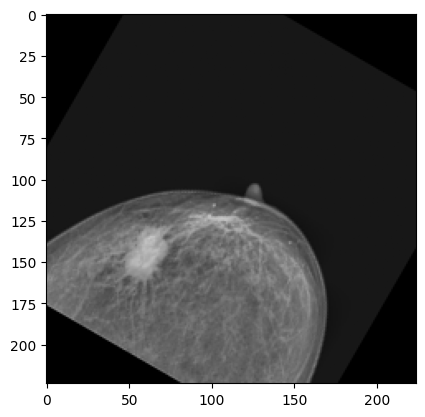

In [14]:
plt.imshow(imgs[0])
print(labels[0])

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
#https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,797,665 (10.67 MB)

 Trainable params: 2,797,665 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = val.n//val.batch_size

In [18]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

In [19]:
history = model.fit(train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=25,
                    callbacks=[csv_logger]) 
model.save('first_model.keras')

Epoch 1/25


/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.6285 - loss: 0.8781 - val_accuracy: 0.6692 - val_loss: 0.6341
Epoch 2/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.7344 - loss: 0.5854

2024-09-06 18:21:57.078768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:21:57.078807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]
/Users/mattsalomon/miniconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7344 - loss: 0.5854 - val_accuracy: 0.6923 - val_loss: 0.5997
Epoch 3/25


2024-09-06 18:21:57.323828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:21:57.323859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.6625 - loss: 0.6554 - val_accuracy: 0.6708 - val_loss: 0.6297
Epoch 4/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.7031 - loss: 0.6148

2024-09-06 18:22:05.109996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:05.110017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7031 - loss: 0.6148 - val_accuracy: 0.6346 - val_loss: 0.6472
Epoch 5/25


2024-09-06 18:22:05.455779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:05.455804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6788 - loss: 0.6338 - val_accuracy: 0.6713 - val_loss: 0.6268
Epoch 6/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.6562 - loss: 0.6447

2024-09-06 18:22:12.906982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:12.907003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6562 - loss: 0.6447 - val_accuracy: 0.6154 - val_loss: 0.6644
Epoch 7/25


2024-09-06 18:22:13.176127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:13.176150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6641 - loss: 0.6414 - val_accuracy: 0.6724 - val_loss: 0.6468
Epoch 8/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.6875 - loss: 0.6683

2024-09-06 18:22:20.624249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:20.624265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mod/_33]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6875 - loss: 0.6683 - val_accuracy: 0.5769 - val_loss: 0.7000
Epoch 9/25


2024-09-06 18:22:20.861931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:20.861949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6786 - loss: 0.6171 - val_accuracy: 0.6697 - val_loss: 0.6216
Epoch 10/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.6406 - loss: 0.6313

2024-09-06 18:22:28.194561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:28.194581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6406 - loss: 0.6313 - val_accuracy: 0.6731 - val_loss: 0.5990
Epoch 11/25


2024-09-06 18:22:28.483359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:28.483381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.6711 - loss: 0.6047 - val_accuracy: 0.6719 - val_loss: 0.6013
Epoch 12/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.7344 - loss: 0.4872

2024-09-06 18:22:35.972480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:35.972499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7344 - loss: 0.4872 - val_accuracy: 0.6154 - val_loss: 0.6843
Epoch 13/25


2024-09-06 18:22:36.245588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:36.245607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6820 - loss: 0.5761 - val_accuracy: 0.6907 - val_loss: 0.5855
Epoch 14/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6719 - loss: 0.5917

2024-09-06 18:22:43.597722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mod/_33]]
2024-09-06 18:22:43.597746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6719 - loss: 0.5917 - val_accuracy: 0.6731 - val_loss: 0.5916
Epoch 15/25


2024-09-06 18:22:43.910925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:43.910946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.7305 - loss: 0.5406 - val_accuracy: 0.7085 - val_loss: 0.5600
Epoch 16/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7188 - loss: 0.5108

2024-09-06 18:22:51.324330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:51.324369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5108 - val_accuracy: 0.8846 - val_loss: 0.4592
Epoch 17/25


2024-09-06 18:22:51.621555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:51.621580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.7623 - loss: 0.4795 - val_accuracy: 0.7430 - val_loss: 0.5477
Epoch 18/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8125 - loss: 0.4485

2024-09-06 18:22:58.969019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:58.969039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.4485 - val_accuracy: 0.7115 - val_loss: 0.4823
Epoch 19/25


2024-09-06 18:22:59.223835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:22:59.223853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.7959 - loss: 0.4313 - val_accuracy: 0.7635 - val_loss: 0.5105
Epoch 20/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8125 - loss: 0.3913

2024-09-06 18:23:06.316314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:06.316348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mod/_33]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.3913 - val_accuracy: 0.8269 - val_loss: 0.4171
Epoch 21/25


2024-09-06 18:23:06.586368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:06.586393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.8290 - loss: 0.3706 - val_accuracy: 0.7732 - val_loss: 0.5063
Epoch 22/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8438 - loss: 0.4084

2024-09-06 18:23:13.776243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:13.776272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/Add/_18]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.4084 - val_accuracy: 0.8462 - val_loss: 0.4948
Epoch 23/25


2024-09-06 18:23:14.053131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:14.053148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.8618 - loss: 0.3099 - val_accuracy: 0.8006 - val_loss: 0.4759
Epoch 24/25
 1/59 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.7812 - loss: 0.5678

2024-09-06 18:23:21.343494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:21.343525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/FloorMod/_22]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7812 - loss: 0.5678 - val_accuracy: 0.7500 - val_loss: 0.4866
Epoch 25/25


2024-09-06 18:23:21.655577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 18:23:21.655609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8830 - loss: 0.2713 - val_accuracy: 0.8254 - val_loss: 0.4121


In [4]:
import pandas as pd
log_data = pd.read_csv('training.log', sep=',', engine='python')

In [28]:
print(X_test.shape, y_test.shape)

(1856, 224, 224, 3) (1856,)


In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.4168233871459961 / Test accuracy: 0.8248922228813171


In [30]:
# Using the saved model
score = restored_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.4168233871459961 / Test accuracy: 0.8248922228813171


In [31]:
y_pred_prob = model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [32]:
# Using the saved model
y_pred_prob = restored_model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [33]:
y_pred_prob

array([[0.9576698 ],
       [0.99994075],
       [0.98049104],
       ...,
       [0.98513675],
       [0.14747404],
       [0.9999653 ]], dtype=float32)

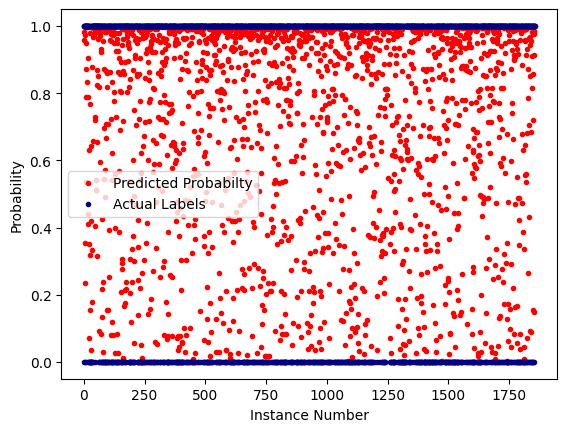

In [34]:
plt.plot(y_pred_prob,'.',color='red',label='Predicted Probabilty')
plt.plot(y_test,'.',color='navy',label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()

In [35]:
y_test

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [36]:
threshold = 0.5
y_pred = np.where(y_pred_prob > threshold, 1,0)
y_pred.squeeze()

array([1, 1, 1, ..., 1, 0, 1])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

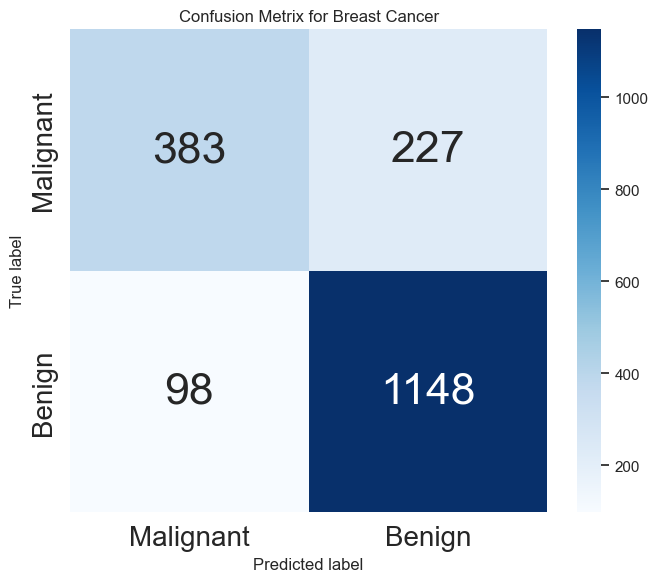

In [37]:
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [38]:
print(classification_report(y_test, y_pred, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.80      0.63      0.70       610
Malignant (Class 1)       0.83      0.92      0.88      1246

           accuracy                           0.82      1856
          macro avg       0.82      0.77      0.79      1856
       weighted avg       0.82      0.82      0.82      1856



In [39]:
from sklearn.metrics import roc_curve, auc

fpr , tpr , thresholds = roc_curve (y_test , y_pred_prob)

area_under_curve = auc(fpr, tpr)

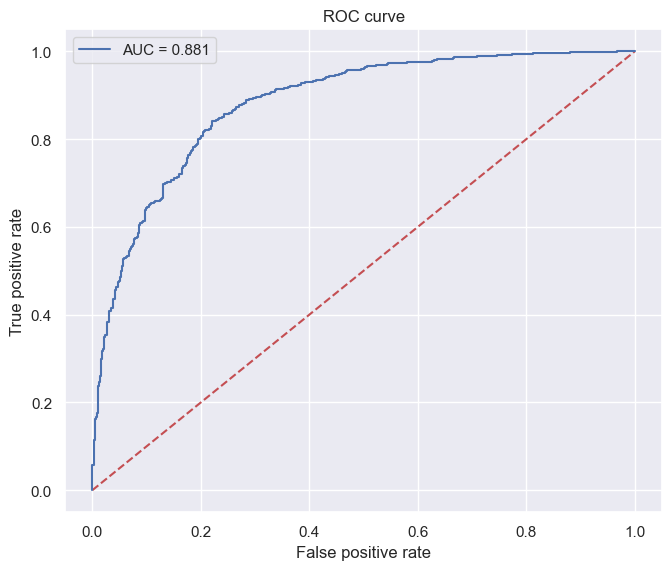

In [40]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
cancer_labels = ['Benign','Malignant']

img_indices = np.random.randint(0, len(X_test), size=[25])
sample_test_images = X_test[img_indices]
sample_test_labels = [cancer_labels[i] for i in y_pred[img_indices].squeeze()]

max_prediction = np.argmax(y_pred_prob, axis=1)
prediction_probs = np.max(y_pred_prob, axis=1)

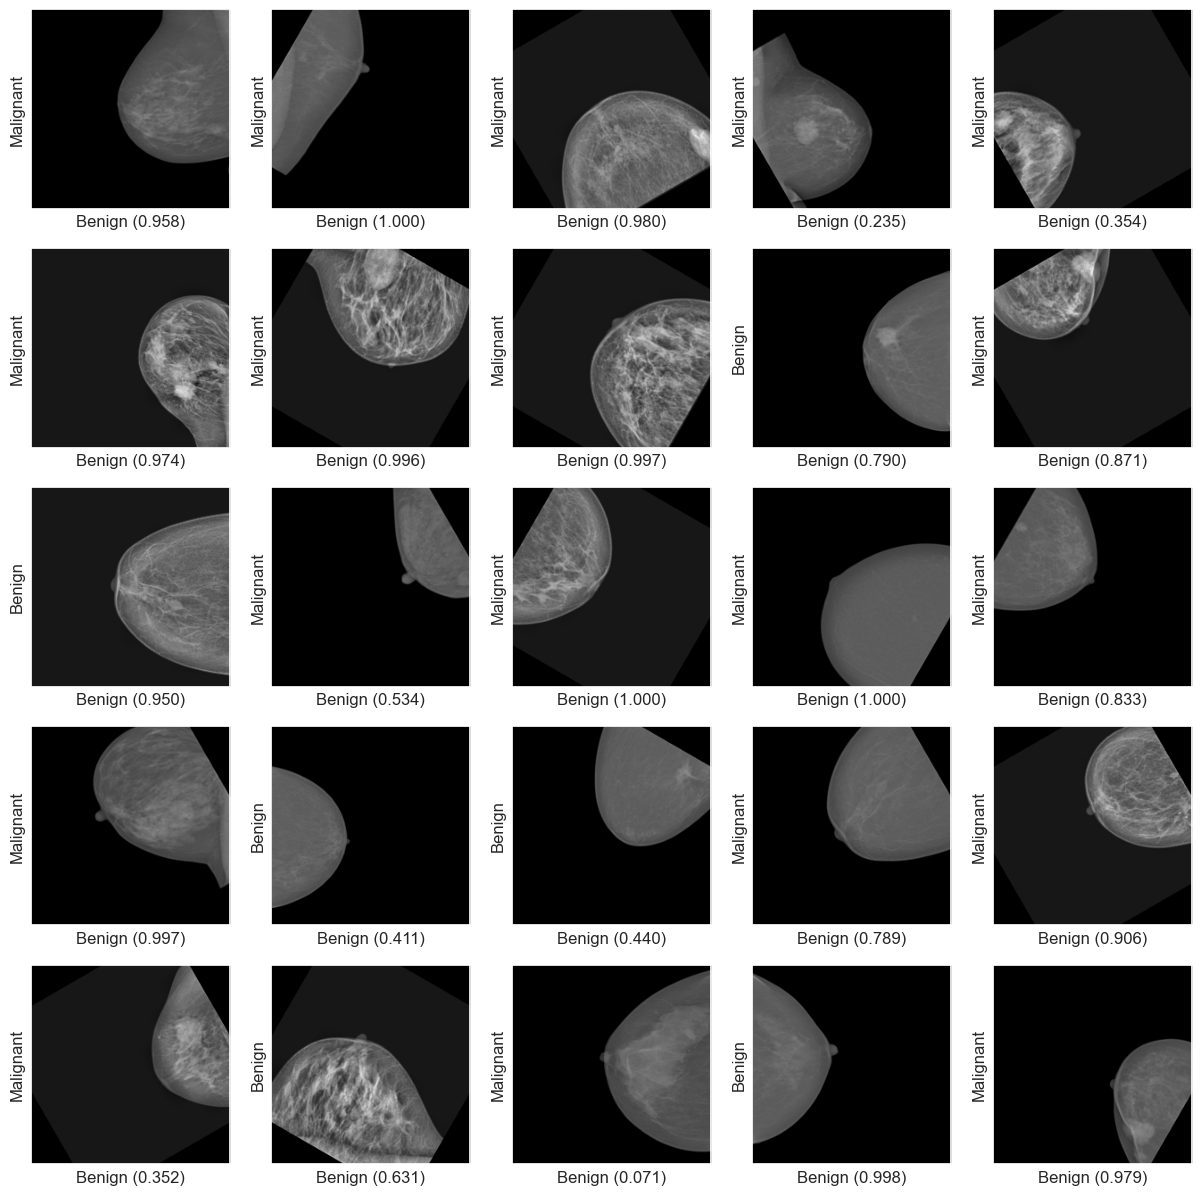

In [87]:
plt.figure(figsize=(15,15))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')

    plt.imshow(img)
    plt.xlabel('{} ({:0.3f})'.format(cancer_labels[prediction], prob))
    plt.ylabel('{}'.format(true_label))


# Transfer Learning using Resnet50

## Feature Extraction (freezing the convolutional bases)

In [88]:
from tensorflow.keras.applications import ResNet50

backbone = ResNet50(input_shape = (224, 224, 3), include_top=False, weights='imagenet')

In [89]:
backbone.trainable = False

In [98]:
# Resnet_model = Sequential()
# Resnet_model.add(backbone)
# Resnet_model.add(Flatten())
# Resnet_model.add(Dense(512, activation='relu'))
# Resnet_model.add(BatchNormalization())
# Resnet_model.add(Dropout(0.05))
# Resnet_model.add(Dense(1, activation='sigmoid'))

Resnet_model = Sequential()
Resnet_model.add(backbone3)
Resnet_model.add(GlobalAveragePooling2D())
Resnet_model.add(Dropout(0.5))
Resnet_model.add(Dense(1, activation='sigmoid'))

In [99]:
Resnet_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

In [100]:
Resnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [101]:
# Checkpoint
filepath="weights.best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [102]:
history = Resnet_model.fit(train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=10)
Resnet_model.save('./Resnet_model.keras')

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.7318 - loss: 0.6394 - val_accuracy: 0.3588 - val_loss: 1.6889
Epoch 2/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.8906 - loss: 0.2399

2024-09-06 22:29:56.390617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 22:29:56.390879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_418/_798]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.8906 - loss: 0.2399 - val_accuracy: 0.3846 - val_loss: 1.6294
Epoch 3/10


2024-09-06 22:30:03.805041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 22:30:03.805101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.9342 - loss: 0.1695 - val_accuracy: 0.3341 - val_loss: 3.9454
Epoch 4/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - accuracy: 0.9844 - loss: 0.1347

2024-09-06 22:33:01.648207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 22:33:01.648431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_418/_798]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9844 - loss: 0.1347 - val_accuracy: 0.1923 - val_loss: 3.9530
Epoch 5/10


2024-09-06 22:33:01.980213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-06 22:33:01.980354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 28605s 493s/step - accuracy: 0.9647 - loss: 0.1062 - val_accuracy: 0.6573 - val_loss: 0.7343
Epoch 6/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - accuracy: 1.0000 - loss: 0.0143

2024-09-07 06:29:51.830450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:29:51.830890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_46/_814]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.7500 - val_loss: 0.5801
Epoch 7/10


2024-09-07 06:29:52.608632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:29:52.608699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9715 - loss: 0.0853 - val_accuracy: 0.6692 - val_loss: 0.6441
Epoch 8/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 3:31 4s/step - accuracy: 1.0000 - loss: 0.0187

2024-09-07 06:33:09.502870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:33:09.503192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_418/_798]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.6346 - val_loss: 0.6838
Epoch 9/10


2024-09-07 06:33:10.172611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:33:10.172695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9912 - loss: 0.0273 - val_accuracy: 0.6703 - val_loss: 1.0281
Epoch 10/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - accuracy: 1.0000 - loss: 0.0081

2024-09-07 06:36:11.199193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:36:11.199260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_418/_798]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.6538 - val_loss: 1.0183


2024-09-07 06:36:11.585484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 06:36:11.585621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [ ]:
Resnet_model = load_model('./Resnet_model.keras')

In [ ]:
score1 = Resnet_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score1[0]} / Test accuracy: {score1[1]}')

In [ ]:
y_pred_prob_2 = Resnet_model.predict(X_test)

In [ ]:
threshold = 0.5
y_pred_2 = np.where(y_pred_prob_2 > threshold, 1,0)
y_pred_2.squeeze()

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

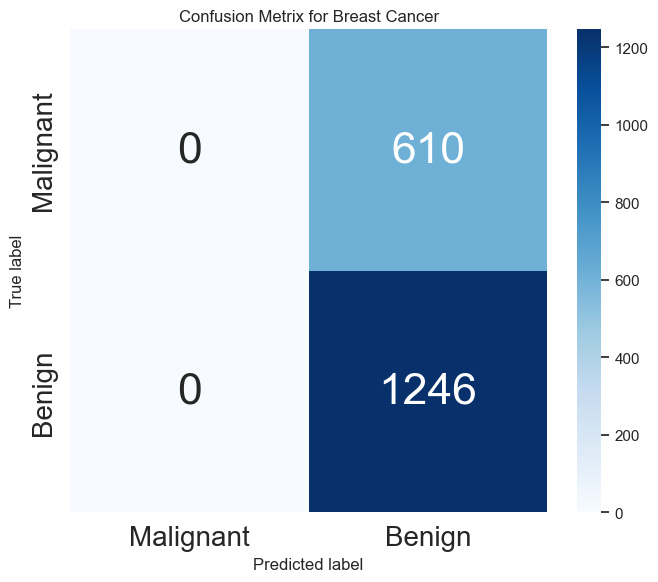

In [68]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_2),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [69]:
print(classification_report(y_test, y_pred_2, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.00      0.00      0.00       610
Malignant (Class 1)       0.67      1.00      0.80      1246

           accuracy                           0.67      1856
          macro avg       0.34      0.50      0.40      1856
       weighted avg       0.45      0.67      0.54      1856



/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattsalomon/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fine Tuning

In [195]:
backbone2 = ResNet50(input_shape = (224, 224, 3), include_top=False, weights='imagenet')

In [ ]:
backbone2.summary()

In [201]:
# from tensorflow.keras.models import Model
# backbone2 = Model(inputs=backbone2.input, outputs=backbone2.layers[80].output)

In [202]:
# backbone2.layers[80]

In [203]:
backbone.trainable = True

In [204]:
# Unfreeze final 2 convolution blocks

# set_trainable = False
# for layer in backbone2.layers:
#     if layer.name == 'block4_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [205]:
# for layer in backbone2.layers:
#     if layer.name.find('conv5')>-1 or layer.name.find('conv4')>-1:
#         print(layer)

In [206]:
# Freeze all layers initially
for layer in backbone2.layers:
    layer.trainable = False

# Unfreeze layers 4 and 5 of ResNet50
for layer in backbone2.layers:
    if layer.name.find('conv5')>-1 or layer.name.find('conv4')>-1:
        layer.trainable = True

In [207]:
resnet50_model_2 = Sequential()
resnet50_model_2.add(backbone2)
resnet50_model_2.add(GlobalAveragePooling2D())
resnet50_model_2.add(BatchNormalization())
resnet50_model_2.add(Dense(64, activation='relu'))
resnet50_model_2.add(BatchNormalization())
#resnet50_model_2.add(Dropout(0.5))
resnet50_model_2.add(Dense(1, activation='sigmoid'))
# Add custom layers on top of the ResNet50 base
# resnet50_model_2.add(Flatten())
# resnet50_model_2.add(Dense(128, activation='relu'))
# resnet50_model_2.add(Dropout(0.5))  # Dropout to prevent overfitting
# resnet50_model_2.add(Dense(64, activation='relu'))
# resnet50_model_2.add(Dense(1, activation='sigmoid'))  # For binary classification

In [208]:
resnet50_model_2.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

In [209]:
resnet50_model_2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_114 (Functional)     │ (None, 28, 28, 512)    │     1,460,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,495,297 (5.70 MB)

 Trainable params: 34,049 (133.00 KB)

 Non-trainable params: 1,461,248 (5.57 MB)

In [210]:
history = resnet50_model_2.fit(train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=10)
resnet50_model_2.save('./resnet50_model_2.keras')

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 558ms/step - accuracy: 0.4691 - loss: 0.8960 - val_accuracy: 0.6724 - val_loss: 0.6492
Epoch 2/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.4375 - loss: 0.7636

2024-09-07 08:56:30.410164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_26]]
2024-09-07 08:56:30.410200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4375 - loss: 0.7636 - val_accuracy: 0.5769 - val_loss: 0.6819
Epoch 3/10


2024-09-07 08:56:33.862654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:56:33.862681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.5114 - loss: 0.7295 - val_accuracy: 0.6713 - val_loss: 0.6525
Epoch 4/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.5625 - loss: 0.6800

2024-09-07 08:56:51.270598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:56:51.270650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add/_26]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5625 - loss: 0.6800 - val_accuracy: 0.6154 - val_loss: 0.6701
Epoch 5/10


2024-09-07 08:56:51.530276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:56:51.530295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.5328 - loss: 0.6959 - val_accuracy: 0.6740 - val_loss: 0.6569
Epoch 6/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.5625 - loss: 0.7174

2024-09-07 08:57:08.158834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:57:08.158856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_20]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5625 - loss: 0.7174 - val_accuracy: 0.5192 - val_loss: 0.6946
Epoch 7/10


2024-09-07 08:57:08.542620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]
2024-09-07 08:57:08.542669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 268ms/step - accuracy: 0.5783 - loss: 0.6724 - val_accuracy: 0.6670 - val_loss: 0.6620
Epoch 8/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.5156 - loss: 0.6723

2024-09-07 08:57:25.120183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:57:25.120207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_16/_24]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5156 - loss: 0.6723 - val_accuracy: 0.7692 - val_loss: 0.6390
Epoch 9/10


2024-09-07 08:57:25.463216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:57:25.463252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - accuracy: 0.5985 - loss: 0.6526 - val_accuracy: 0.6595 - val_loss: 0.6666
Epoch 10/10
 1/59 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.5938 - loss: 0.6417

2024-09-07 08:57:42.045535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:57:42.045556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_20]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5938 - loss: 0.6417 - val_accuracy: 0.6346 - val_loss: 0.6752


2024-09-07 08:57:42.317880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-07 08:57:42.317911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_6]]


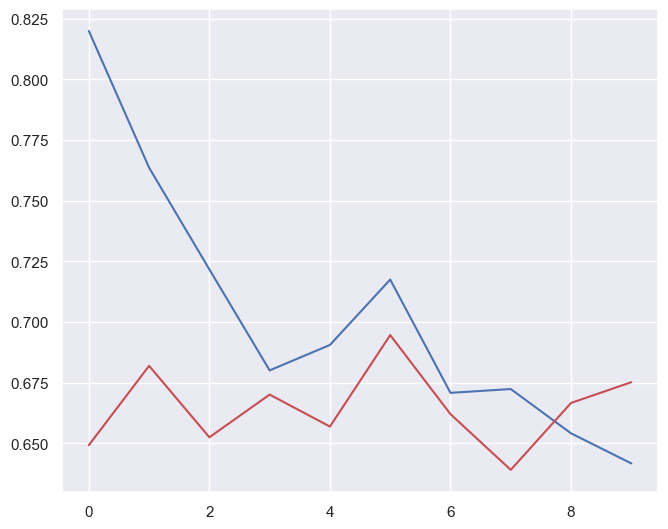

In [211]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'r')

In [212]:
resnet50_model_2 = load_model('./resnet50_model_2.keras')

In [213]:
score2 = resnet50_model_2.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 0.6666148900985718 / Test accuracy: 0.6600215435028076


In [214]:
y_pred_prob_3 = resnet50_model_2.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step


In [215]:
threshold = 0.5
y_pred_3 = np.where(y_pred_prob_3 > threshold, 1,0)
y_pred_3.squeeze()

array([1, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

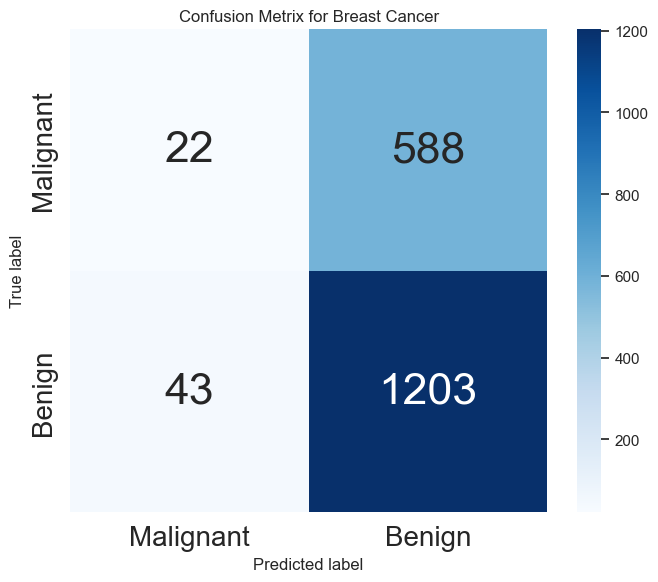

In [216]:
sns.set(rc={'figure.figsize':(7.7,6.27)})

sns.heatmap(confusion_matrix(y_test,y_pred_3),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [217]:
print(classification_report(y_test, y_pred_3, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.34      0.04      0.07       610
Malignant (Class 1)       0.67      0.97      0.79      1246

           accuracy                           0.66      1856
          macro avg       0.51      0.50      0.43      1856
       weighted avg       0.56      0.66      0.55      1856

